<a href="https://colab.research.google.com/github/SolAtomizer/Portfolio/blob/main/Telecom_CustomerClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyse de segmentation des clients**
---
Laurent Castonguay

## Préparation des données


#### Import des librairies nécessaires globales

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Import et nettoyage des données

In [19]:
#variable "Path" non nécessaire/absente dû à l'utilisation de l'IDE Google Colaboratory
FILE_NAME = 'Telecom_CustomerClustering.xlsx'
df = pd.read_excel(FILE_NAME)

In [20]:
#Changement d'options de print afin d'offrir une meilleure visibilité des sorties
pd.options.display.max_columns = 9
pd.options.display.width = 250

In [21]:
#Vérification des types de données
print(f"Types:\n {df.dtypes}")

#Les variables sont bien classées à l'exception de TotalCharges qui est "Object".
#La fonction ci-dessous permet de la transformer en nombre, l'option 'coerce' transforme les cellules vides en valeurs nulles
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors = 'coerce')

#Vérification de doublons de clients, subset sur les customerID pour voir si un client est présent plus d'une fois.
#Dans le cas où un ID serait dupliqué mais les valeurs seraient différentes, il faudrait trancher entre les duplicatas.
#Ce n'est pas le cas ici, on conserve donc le premier ID seulement.
duplicates = df[df.duplicated(subset = ['customerID'])]

#Imprimer une liste des clients en doublons pour les vérifier
print(f"\nDuplicatas:\n {duplicates['customerID'].values}")

#Éliminer les doublons, on conserve le premier ID seulement. (Valeur par défault de la fonction donc paramètre non nécessaire)
#Ignorer les indexs est crucial pour la jointure des clusters créés par le Kmeans au df initial (non standardisé)
df.drop_duplicates(ignore_index = True, inplace = True)

#Vérification des duplicatas, cette liste est maintenant vide
duplicates2 = df[df.duplicated(subset = ['customerID'])]
print(f"\nVérification: {duplicates2.values}")

Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Kids                 object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Duplicatas:
 ['4080-IIARD' '8149-RSOUN' '3082-VQXNH' '4088-YLDSU' '9128-CPXKI'
 '6595-COKXZ' '3021-VLNRJ' '6260-XLACS' '2330-PQGDQ']

Vérification: []


In [22]:
#Vérification des données manquantes
print(df.isna().sum())

#Remplacement des valeurs manquantes de Kids et Contract par leur mode
#value_counts permet de compter les valeurs distinctes et idxmax retourne seulement la valeur la plus commune
KidsMode = df.Kids.value_counts().idxmax()
ContractMode = df.Contract.value_counts().idxmax()

#Remplacement des valeurs nulles par le mode assigné aux variables ci-dessus
df.Kids = df.Kids.fillna(KidsMode)
df.Contract = df.Contract.fillna(ContractMode)

#Remplacement des paiements mensuels ou totaux manquants selon leur calcul
#Ces valeurs calculées sont approximatives, mais les résultats demeurent
#adéquats à des fins de création d'algorithmes de regroupement comme Apriori et Kmeans
#Étant donné la faible quantité de valeurs nulles, le remplacement de celles-ci n'a pas besoin
#d'être complexe et n'affectera peu les modèles créés.
Monthly_Charges = df.TotalCharges / df.tenure
Total_Charges = df.tenure * df.MonthlyCharges

#Remplacement des valeurs nulles par le calcul approximatif assigné aux variables ci-dessus
df.MonthlyCharges = df.MonthlyCharges.fillna(Monthly_Charges)
df.TotalCharges = df.TotalCharges.fillna(Total_Charges) 

#Validation, on ne retrouve plus de valeurs nulles
print(df.isna().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Kids                 2
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             3
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       4
TotalCharges        11
Churn                0
dtype: int64
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Kids                0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [23]:
#Vérification rapide de valeurs numériques abérantes
print(df.describe())

#À première vue, il ne semble pas avoir de données numériques aberrantes. La durée de vie de 5 ans couplées aux charges 
#mensuelles les plus élevées donnent un résultat très similaire au charges totales maximales du jeu de données.
#Le minimum de charges totales de 0$ est notable, vérifions ces valeurs.
Zeroes = df[df['TotalCharges'] == 0]
print(f"\n {Zeroes[['customerID','tenure','MonthlyCharges','TotalCharges']]}")

#Étant donné que ces clients n'ont pas complété leur premier mois,
#des charges totales de 0 sont logiques et n'Ont pas à être corrigées ou éliminées 

       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.762120   2279.734304
std         0.368612    24.559481       30.090451   2266.794470
min         0.000000     0.000000       18.250000      0.000000
25%         0.000000     9.000000       35.500000    398.550000
50%         0.000000    29.000000       70.350000   1394.550000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000

       customerID  tenure  MonthlyCharges  TotalCharges
488   4472-LVYGI       0           52.55           0.0
753   3115-CZMZD       0           20.25           0.0
936   5709-LVOEQ       0           80.85           0.0
1082  4367-NUYAO       0           25.75           0.0
1340  1371-DWPAZ       0           56.05           0.0
3331  7644-OMVMY       0           19.85           0.0
3826  3213-VVOLG       0           25

#### Préparations aditionnelles pour l'utilisation d'Apriori et de Kmeans *clustering*

In [24]:
#Afin de pouvoir utiliser l'information des données numériques, on doit les transformer en valeurs catégoriques
#Création de 3 catégories selon les quartiles pour les données numériques, +1 afin de simplifier la compréhension
#Python compte à partir de 0 mais cela pourrait porter à confusion dans un contexte de quartiles
df['tenureQuartiles'] = pd.qcut(df['tenure'], 3, labels = False)+1
df['MonthlyQuartiles'] = pd.qcut(df['MonthlyCharges'], 3, labels = False)+1
df['TotalQuartiles'] = pd.qcut(df['TotalCharges'], 3, labels = False)+1

#La variable créée TotalQuartiles est fortement corrélée avec les deux autres, réduisant sa pertinence.
#Par contre, elle pourrait contribuer légèrement au Kmeans clustering.

#Vérification
print(df[['tenure','tenureQuartiles','MonthlyCharges', 'MonthlyQuartiles','TotalCharges','TotalQuartiles']])

      tenure  tenureQuartiles  MonthlyCharges  MonthlyQuartiles  TotalCharges  TotalQuartiles
0          1                1           29.85                 1         29.85               1
1         34                2           56.95                 2       1889.50               2
2          2                1           53.85                 2        108.15               1
3         45                2           42.30                 1       1840.75               2
4          2                1           70.70                 2        151.65               1
...      ...              ...             ...               ...           ...             ...
7038      24                2           84.80                 3       1990.50               2
7039      72                3          103.20                 3       7362.90               3
7040      11                1           29.60                 1        346.45               1
7041       4                1           74.40               

In [25]:
#Afin d'utiliser les algorithmes, il faut binariser les données catégoriques

#Fonction qui permet de binariser toutes les colonnes contenues dans un df
#selon une liste de colonnes données (todummy_list)
def dummy_df(dframe, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(dframe[x], prefix=x) #Application de la fonction get_dummies selon la colonne
        dframe = dframe.drop(x, 1)                    #Retrait de l'ancienne colonne dans le df cible
        dframe = pd.concat([dframe, dummies], axis=1) #Ajout des colonnes binarisés dans le df cible
    return dframe

#Création d'un df contenant uniquement les colonnes à binariser pour Kmeans
Categoric = df.drop(df[['customerID','tenure','MonthlyCharges','TotalCharges']],1)

#Application de la fonction pour créer le df pour le Kmeans clustering
binary_df = dummy_df(df, Categoric)
#Vérification
print(binary_df)

#Création d'un df contenant uniquement les colonnes à binariser pour Apriori
#On retire plus de colonnes, donc celles ayant rapport aux options de forfait
#Ces colonnes sont très interreliées et causent beaucoup de "bruit",
#c'est-à-dire qu'elles causent beaucoup de règles d'association qui ne sont pas très intéressantes
#à des fins de segmentation de clientèle. (ex: OnlineSecurity = No Internet Service lié à InternetService = no)
apriori_df = df.drop(['customerID','tenure', 'MonthlyCharges','TotalCharges', 'TotalQuartiles', 'OnlineSecurity',
                        'MultipleLines', 'InternetService','PhoneService','OnlineBackup',
                      'DeviceProtection','TechSupport','StreamingTV','StreamingMovies'],1)

#Application de la fonction pour créer le df pour l'algorithme Apriori
#Même df pour les deux arguments car on veut binariser toutes les colonnes présentes
apriori_df = dummy_df(apriori_df,apriori_df)
#Vérification 
print(apriori_df)

      customerID  tenure  MonthlyCharges  TotalCharges  ...  MonthlyQuartiles_3  TotalQuartiles_1  TotalQuartiles_2  TotalQuartiles_3
0     7590-VHVEG       1           29.85         29.85  ...                   0                 1                 0                 0
1     5575-GNVDE      34           56.95       1889.50  ...                   0                 0                 1                 0
2     3668-QPYBK       2           53.85        108.15  ...                   0                 1                 0                 0
3     7795-CFOCW      45           42.30       1840.75  ...                   0                 0                 1                 0
4     9237-HQITU       2           70.70        151.65  ...                   0                 1                 0                 0
...          ...     ...             ...           ...  ...                 ...               ...               ...               ...
7038  6840-RESVB      24           84.80       1990.50  ...   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


      gender_Female  gender_Male  SeniorCitizen_0  SeniorCitizen_1  ...  tenureQuartiles_3  MonthlyQuartiles_1  MonthlyQuartiles_2  MonthlyQuartiles_3
0                 1            0                1                0  ...                  0                   1                   0                   0
1                 0            1                1                0  ...                  0                   0                   1                   0
2                 0            1                1                0  ...                  0                   0                   1                   0
3                 0            1                1                0  ...                  0                   1                   0                   0
4                 1            0                1                0  ...                  0                   0                   1                   0
...             ...          ...              ...              ...  ...                ...    

## Exploration préalable des données

#### Statistiques descriptives et graphiques fait avec Seaborn afin d'explorer les données et déceler des tendances

In [26]:
#Application d'un thème et d'une palette pour le notebook complet afin d'améliorer la lisibilité
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'axes.grid': True}
sns.set_theme(style="ticks", rc=custom_params, palette ='tab10')

Status d'attrition :
No     0.73463
Yes    0.26537
Name: Churn, dtype: float64



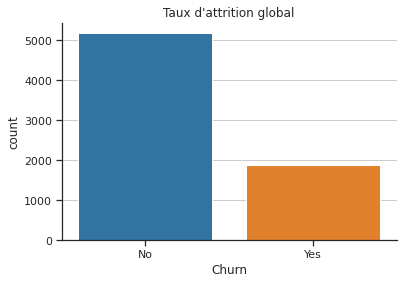

In [27]:
#Calcul du taux d'attrition global
churn_g = sns.countplot(data = df, x ='Churn')
plt.title("Taux d'attrition global")

ChurnedRatio = df.Churn.value_counts(normalize= True)
print(f"Status d'attrition :\n{ChurnedRatio}\n")
#Globalement, on observe qu'environ 26% des clients ont quittés.
#Ceci peut être utilisé comme base afin de déceler quelles variables
#ont des taux d'attritions plus élevés que l'ensemble des clients

Churn
No     61.265706
Yes    74.441332
Name: MonthlyCharges, dtype: float64


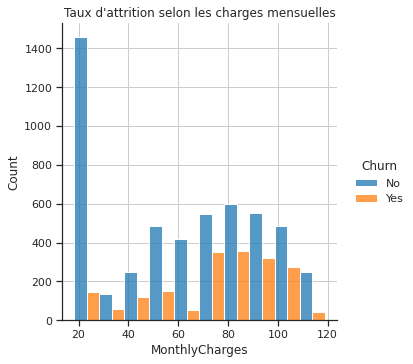

In [28]:
#Histogramme des paiements mensuels selon le statut d'attrition
sns.displot(data= df, x= 'MonthlyCharges', bins= 10, hue= 'Churn', multiple= 'dodge')
plt.title("Taux d'attrition selon les charges mensuelles")
#Il semblerait que plus les charges mensuelles sont élevées, plus les clients ont tendance à quitter.

#Vérification avec une moyenne des charges mensuelles selon le statut d'attrition
MonthlyC_Churn = df.groupby('Churn')['MonthlyCharges'].mean()
print(MonthlyC_Churn)
#Les clients ayant quittés ont en effet des charges mensuelles plus élevées en moyenne

Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64 

% d'anciens clients ayant quitté avant la fin du 2e mois: 20.33%


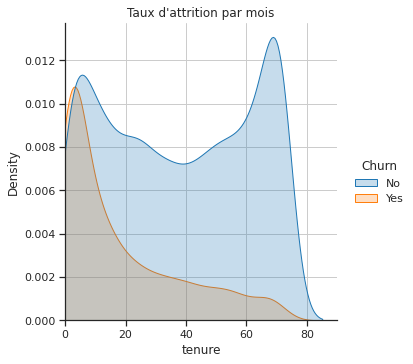

In [29]:
# Observation de l'attrition selon la durée de vie du client
Graph = sns.displot(data = df, x = 'tenure', kind = 'kde',hue = 'Churn', fill = True)
Graph.set(xlim=(0,90))
plt.title("Taux d'attrition par mois")
#Les clients semblent quitter généralement très tôt dans leur durée de vie, dans les premiers mois.

#Vérification avec une moyenne selon le statut d'attrition
tenure_Churn = df.groupby('Churn')['tenure'].mean()

#Calcul du % des clients ayant quittés qui l'ont fait avant la fin du 2e mois
Churned = df[df.Churn == 'Yes']
Churn_2Months = len(Churned[Churned.tenure <= 1])/len(Churned)

print(tenure_Churn, "\n\n% d'anciens clients ayant quitté avant la fin du 2e mois:", "{:2.2%}".format(Churn_2Months))
#La durée de vie des clients ayant quittés est en moyenne 20 moins plus courte que ceux ayant resté.
#Environ 20% des clients qui ont quittés le font avant la fin du 2e mois

PaymentMethod              Churn
Electronic check           No       0.547146
                           Yes      0.452854
Mailed check               No       0.808933
                           Yes      0.191067
Bank transfer (automatic)  No       0.832902
                           Yes      0.167098
Credit card (automatic)    No       0.847569
                           Yes      0.152431
Name: Churn, dtype: float64


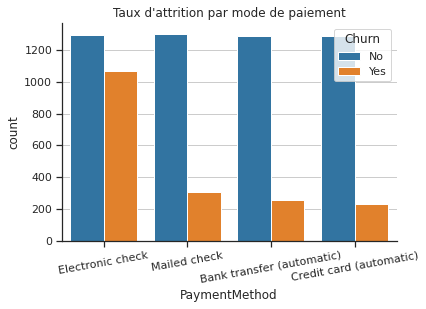

In [30]:
#Histogramme horizontal du taux d'attrition selon le mode de paiement des clients
g = sns.countplot(data = df, x= 'PaymentMethod', hue = 'Churn')
plt.title("Taux d'attrition par mode de paiement")
g.set_xticklabels(g.get_xticklabels(),rotation = 10)
#Bien que le mode de paiement le plus populaire,
#les clients payant par chèque électronique ont le taux d'attrition relatif le plus élevé 

#Vérification avec le ratio d'attrition par mode de paiement
Payment_ChurnRatio =  df.groupby('PaymentMethod', sort = False)['Churn'].value_counts(normalize = True, sort = True)
print(Payment_ChurnRatio)
#Les clients payant par chèque électronique ont un taux d'attrition d'environ 45%.
#Ce mode de paiement est le seul avec un taux d'attrition supérieur à 20%!

Contract        Churn
Month-to-month  No       0.573124
                Yes      0.426876
One year        No       0.887228
                Yes      0.112772
Two year        No       0.971665
                Yes      0.028335
Name: Churn, dtype: float64


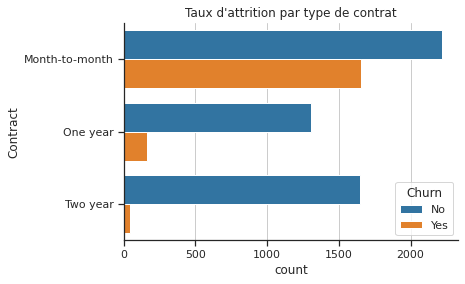

In [31]:
#Histogramme horizontal du taux d'attrition selon le type de contrat
sns.countplot(data = df, y = 'Contract', hue = 'Churn')
plt.title("Taux d'attrition par type de contrat")
#Les contrats mensuels sont les plus populaires, 
#ils ont aussi le taux d'attrition le plus élevé, ce qui n'est pas surprenant. 

#Vérification avec le ratio d'attrition par type de contrat
Contract_ChurnRatio =  df.groupby('Contract', sort = False)['Churn'].value_counts(normalize = True, sort = True)
print(Contract_ChurnRatio)
#Les clients ayant un contrat mensuel ont un taux d'attrition environnant 42%.
#Au contraire, les clients ayant des contrats de deux ans ont taux d'attrition inférieur à 3%.

PhoneService  Churn
No            No       0.750733
              Yes      0.249267
Yes           No       0.732904
              Yes      0.267096
Name: Churn, dtype: float64


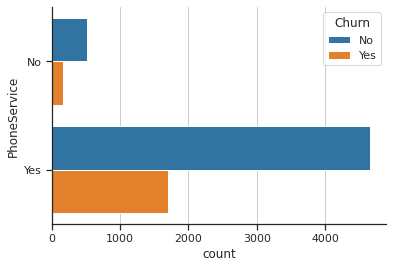

In [32]:
#Histogramme horizontal du taux d'attrition selon le fait d'avoir le service téléphonique
sns.countplot(data = df, y = 'PhoneService', hue='Churn')

#Vérification avec le ratio d'attrition selon le fait d'avoir une ligne téléphonique
PhoneService_ChurnRatio = df.groupby(['PhoneService'])['Churn'].value_counts(normalize=True)
print(PhoneService_ChurnRatio)

#la différence entre les deux modalités de cette variable est minime et ne semble pas significative.
#L'attrition se rapproche fortement de la moyenne globale pour les deux modalités.

MultipleLines     Churn
No                No       0.749558
                  Yes      0.250442
No phone service  No       0.750733
                  Yes      0.249267
Yes               No       0.713901
                  Yes      0.286099
Name: Churn, dtype: float64


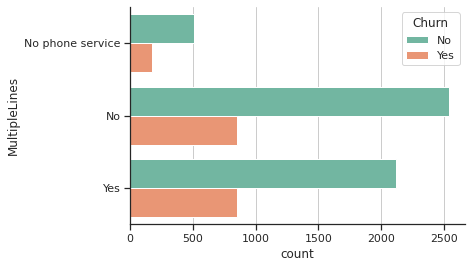

In [33]:
#Histogramme horizontal du taux d'attrition selon le fait d'avoir plus d'une ligne téléphonique
sns.countplot(data = df, y = 'MultipleLines', hue='Churn',  palette = 'Set2')

#Vérification avec le ratio d'attrition par nombre de ligne téléphonique
MultipleLines_ChurnRatio = df.groupby(['MultipleLines'])['Churn'].value_counts(normalize=True)
print(MultipleLines_ChurnRatio)

#Le taux d'attrition des clients semble rester relativement similaire peu importe le nombre de lignes téléphoniques.
#On retrouve une très légère hausse d'attrition chez les clients ayant plus d'une ligne, mais cela ne semble pas significatif.

InternetService
DSL            58.103077
Fiber optic    91.500756
No             21.078453
Name: MonthlyCharges, dtype: float64


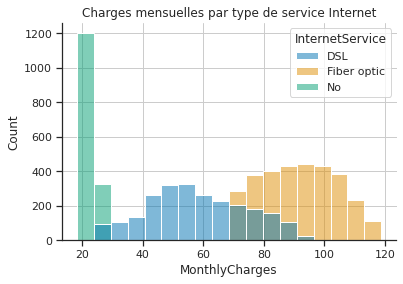

In [34]:
#Histogramme des paiements mensuels selon leur type de service Internet
sns.histplot(data= df, x= 'MonthlyCharges', hue= 'InternetService',
            multiple= 'layer', fill = True, palette = 'colorblind')
plt.title("Charges mensuelles par type de service Internet")
#Les client sans internet ont des charges mensuelles très homogènes et qui sont les plus faibles.
#L'internet à fibre optique semble le plus dispendieux, ce qui n'est pas surprenant.

#Vérification avec une moyenne des charges mensuelles moyennes par type de service Internet
MonthlyC_InternetService = df.groupby('InternetService')['MonthlyCharges'].mean()
print(MonthlyC_InternetService)
#Les clients sans internet payent en moyenne environ 21$/mois, ceux avec la fibre optique 91.50$ en moyenne.

InternetService  Churn
DSL              No       0.810409
                 Yes      0.189591
Fiber optic      No       0.581072
                 Yes      0.418928
No               No       0.925950
                 Yes      0.074050
Name: Churn, dtype: float64 

Durée de vie moyenne par type de service Internet pour les anciens clients:
 InternetService
DSL            14.111111
Fiber optic    20.196608
No              8.238938
Name: tenure, dtype: float64


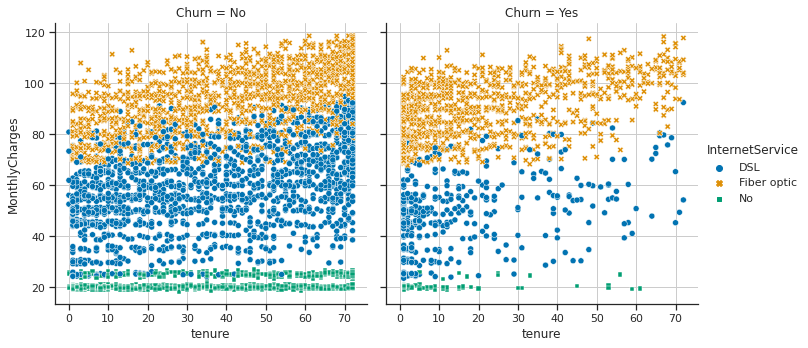

In [35]:
#Nuages de points comparatifs corrélant la durée de vie avec les charges mensuelles comparés selon le service Internet
sns.relplot(data = df, x = 'tenure', y = 'MonthlyCharges',  style = 'InternetService', hue = 'InternetService',
            col = 'Churn', palette = 'colorblind')
#La distribution des points semble relativement égale pour les clients restants, mais les clients ayant quittés se situent 
#majoritairement parmi ceux ayant les paiements les plus élevés, ayant l'Internet à fibre optique.
#Les clients sans internet semblent avoir un très faible taux d'attrition

#Vérification avec le ratio d'attrition par type de service Internet
#On calcule aussi la durée de vie moyenne d'anciens client par type de service
InternetService_ChurnRatio =  df.groupby('InternetService', sort = False)['Churn'].value_counts(normalize = True, sort = True)
InternetService_tenure =   Churned.groupby('InternetService', sort = False)['tenure'].mean()

print(InternetService_ChurnRatio,
      '\n\nDurée de vie moyenne par type de service Internet pour les anciens clients:\n',
      InternetService_tenure)

#Les clients ayant l'Internet à fibre optique quittent à un ratio beaucoup plus élevé que les autres services, environ 42%
#Cependant, ils ont tendance à quitter plus tard que les autres types de services, ayant une durée de vie moyenne de 20 mois.
#Ce résultat est plûtot surprenant, bien qu'ils quittent plus souvent que les autres services, ils restent plus longtemps.
#Les clients ayant d'autres types de services semblent quitter relativement tôt ou rester loyaux à long terme,
#L'attrition des clients à fibre optique est répandue plus également selon leur durée de vie, comme le graphique démontre bien.

OnlineBackup         Churn
No                   No       0.600712
                     Yes      0.399288
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.784685
                     Yes      0.215315
Name: Churn, dtype: float64 

DeviceProtection     Churn
No                   No       0.608724
                     Yes      0.391276
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.774979
                     Yes      0.225021
Name: Churn, dtype: float64 

TechSupport          Churn
No                   No       0.583645
                     Yes      0.416355
No internet service  No       0.925950
                     Yes      0.074050
Yes                  No       0.848337
                     Yes      0.151663
Name: Churn, dtype: float64 

StreamingTV          Churn
No                   No       0.664769
                     Yes      0.335231
No internet service  N

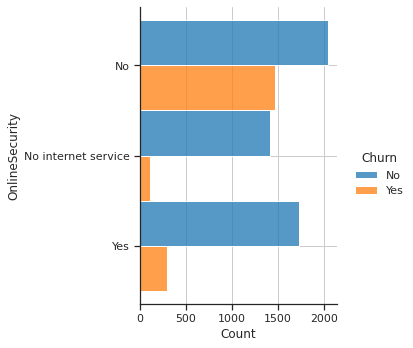

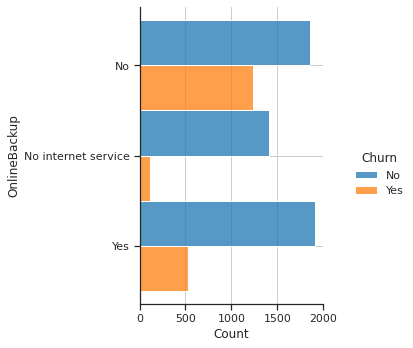

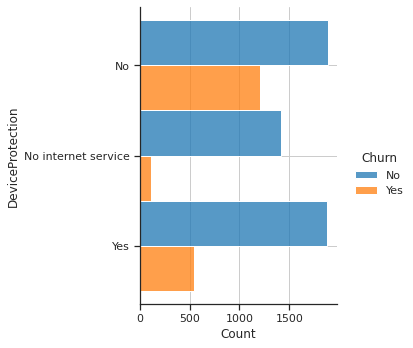

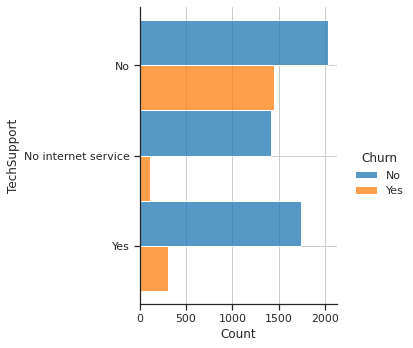

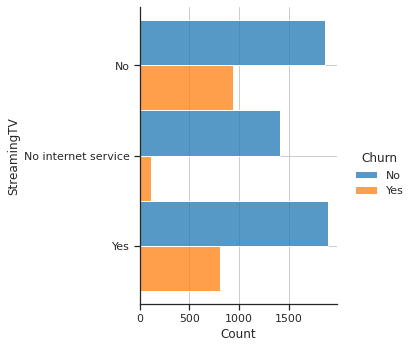

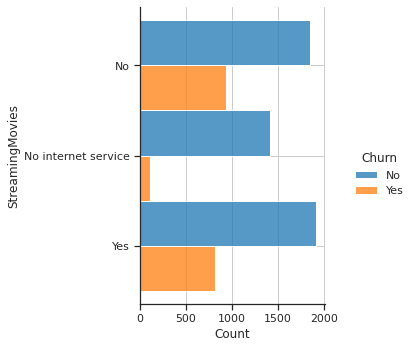

In [36]:
#Plusieurs colonnes sont liées à des options supplémentaires quant aux abonnements des clients
#Afin de les observer, on observe simplement leur taux d'attrition par modalité.

#Vérification des différences de taux d'attrition par colonnes liées aux options
Options_cols = df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]

#Boucle itérative vérifiant le status d'attrition selon les options
for col in Options_cols:
    df = df.sort_values(col) #tri afin de toujours avoir le même ordre de colonnes et couleurs 
    sns.displot(data = df,  y = col,hue = 'Churn', multiple = 'dodge', hue_order = ['No','Yes'])


#Création d'une liste vide et boucle itérative permettant de calculer
#le ratio d'attrition par option supplémentaire
Options = []
for col in Options_cols:
  Options.append(df.groupby(col)['Churn'].value_counts(normalize = True, sort = True))

#Boucle itérative imprimant les résultats par option supplémentaire
colnumb = 0
for i in range(0,5):
  colnumb += 1
  print(Options[colnumb],'\n')

#Tel que vu dans les analyses précédentes, les clients sans service internet ont un faible taux d'attrition.
#Surprenamment, les clients ayant des options (Yes), ont très souvent des taux d'attrition plus faible que ceux sans l'option
#Ceci est surprenant, car l'attrition à tendance à augmenter lorsque les frais mensuels augmentent.
#Pourtant, les clients avec des options comme OnlineSecurity ou TechSupport quittent à plus bas rythme que la moyenne de 26%.
#Par contre, le fait d'avoir StreamingTV ou StreamingMovies augmente légèrement l'attrition comparativement au taux global.

## Création d'un modèle avec l'algorithme Apriori

#### Création du modèle Apriori

In [37]:
#import de la librairie mlxtend pour la création de règles
from mlxtend.frequent_patterns import apriori, association_rules

#Création du modèle et des règles, avec un support minimal de 8% et une confiance de 60%
aprio = apriori(apriori_df, min_support = 0.08, use_colnames = True)
rules = association_rules(aprio, metric = 'confidence', min_threshold= 0.6)

#L'algorithme Apriori est très particulier à optimiser, il faut procéder avec
#une approche "essai-erreur" avec les paramètres afin de créer des règles intéressantes.
#Des données trop interreliées ou des paramètres trop permissifs mènent à des règles
#qui ont peu d'utilité dans une optique de segmentation de la clientèle.

#### Règles d'association ordonnancées selon leur lift et confiance

In [38]:
#Ordonnancement des règles
rules = rules.sort_values(['lift','confidence'], ascending = [False, False])

#Filtre sur les règles afin de seulement considérer les conséquences portant sur le taux d'attrition.
#À des fins d'utilisation dans ce contexte, Apriori permet de générer des pistes de solution et de trouver des
#causes d'attrition diverses, qui pourraient être surprenantes. Le Kmeans sera utilisé d'avantage pour segmenter les clients.
rules[rules['consequents'].astype(str).str.contains('Churn_')]

#n.b. présentation dans le notebook peu importante, les règles seront présentées plus esthétiquement dans le slidedoc.
#Afin de déceler des règles intéressantes, il a fallu modifier plusieurs fois les paramètres de support, confiance et même
#lift minimal. Cet algorithme requiert beaucoup de travail manuel et d'interprétation et ses résultats sont mitigés dans ce cas,
#expliquant pourquoi l'on procède avec le Kmeans pour la segmentation et les recommandations.

#Il serait bien sûr possible d'appliquer Apriori à la suite de la création des clusters par le Kmeans,
#mais ceci n'offre pas réellement de pistes de solution intéressantes.
#Il est plus facile de déceler, comprendre et agir sur des trouvailles faites avec des statistiques descriptives par cluster.
#Pour cette raison, Apriori est fait avant l'ajout de cluster afin de déceler des liens intéressants ou de confimer des liens
#qui ont été décelés dans la phase d'exploration de données ci-dessus.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2825,"(SeniorCitizen_0, tenureQuartiles_3, Paperless...","(Churn_No, Contract_Two year)",0.118841,0.233707,0.080931,0.681004,2.913918,0.053157,2.402199
2827,"(tenureQuartiles_3, PaperlessBilling_No)","(Churn_No, Contract_Two year, SeniorCitizen_0)",0.131904,0.213971,0.080931,0.613563,2.867501,0.052708,2.034041
2145,"(tenureQuartiles_3, PaperlessBilling_No)","(Churn_No, Contract_Two year)",0.131904,0.233707,0.087037,0.659849,2.823401,0.056210,2.252804
2698,"(Contract_Two year, Partner_Yes)","(tenureQuartiles_3, Churn_No, SeniorCitizen_0)",0.169246,0.250177,0.117706,0.695470,2.779906,0.075364,2.462227
2149,"(PaperlessBilling_Yes, Contract_Two year)","(tenureQuartiles_3, Churn_No)",0.111316,0.295471,0.089025,0.799745,2.706681,0.056134,3.518159
...,...,...,...,...,...,...,...,...,...
551,"(Contract_Month-to-month, Partner_Yes)",(Churn_No),0.196081,0.734630,0.119409,0.608979,0.828960,-0.024638,0.678659
345,"(Contract_Month-to-month, SeniorCitizen_0)",(Churn_No),0.435894,0.734630,0.263524,0.604560,0.822945,-0.056697,0.671075
2092,"(PaperlessBilling_Yes, MonthlyQuartiles_2, Kid...",(Churn_No),0.156751,0.734630,0.094704,0.604167,0.822409,-0.020450,0.670408
2308,"(Contract_Month-to-month, gender_Male, SeniorC...",(Churn_No),0.150362,0.734630,0.090728,0.603399,0.821365,-0.019732,0.669111


## Création d'un modèle avec un algorithme de Kmeans *clustering*

#### Utilisation de la *elbow method* afin de déterminer le nombre de nuées idéal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


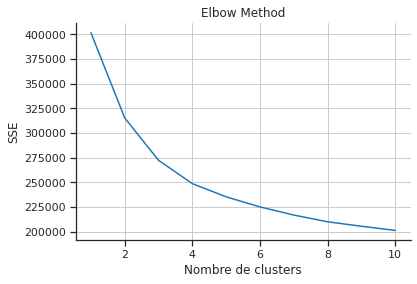

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#création d'un dataframe à partir du df créé par la fonction de binarisation
kmeans_df = binary_df.drop('customerID',1)
#Standardisation des données
scaled_kmeans_df = StandardScaler().fit_transform(kmeans_df)
#Combinaison des données standardisées avec les titres de colonnes du df binarisé
kmeans_df = pd.DataFrame(scaled_kmeans_df, columns = kmeans_df.columns)


#Création d'une liste vide afin d'y ajouter le SSE (Within-Cluster Sum of Squares, en anglais)
WCSS = []

#Création d'une boucle itérative testant le WCSS selon le nombre de nuées
#n.b. argument random_state optionnel mais permet de recréer les résultats au besoin, 812 choisi pour le sigle du cours
#la portée de 1 à 10 nuées choisie arbitrairement, devrait être suffisant pour trouver un nombre optimal
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 812)
    kmeans.fit_transform(kmeans_df)
    WCSS.append(kmeans.inertia_)
elbow = sns.lineplot(range(1, 11), WCSS)
plt.title('Elbow Method')
plt.xlabel('Nombre de clusters');
plt.ylabel('SSE');
#On apperçoit bel et bien que le SSE réduit drastiquement jusqu'à 4 clusters, qui sera le nombre de clusters choisi

#### Création du modèle et ajout aux données originales

In [40]:
#Création des clusters
kmeans = KMeans(n_clusters=4, init = 'k-means++', random_state = 812)

#Création de la colonne "Cluster", +1 afin de simplifier sa compréhension
kmeans_df['Cluster'] = kmeans.fit_predict(kmeans_df)+1
#Transformation de la colonne en donnée catégorique (permet de les représenter adéquatement dans les graphiques)
kmeans_df['Cluster'] = kmeans_df['Cluster'].astype('category')

#Ajout de la colonne Cluster sur la df originale (Series revient essentiellement à un "join" sur l'index)
df['Cluster'] = pd.Series(kmeans_df['Cluster'],index = df.index)

#Vérification, retourne "True" si les colonnes sont égales sur l'ensemble des lignes
df['Cluster'].equals(kmeans_df['Cluster'])

#Les clusters sont maintenant ajoutés au dataframe initial. Ceci permettra de faire des statistiques descriptives par cluster.
#Bien que le Kmeans permet de regrouper les observations, il ne fourni pas nécessairement de pistes de solution comme Apriori,
#c'est pourquoi il faut procéder à des analyses descriptives rigoureuses selon les nombreuses variables du jeu de données.
#Observer les différences parmi les clusters permet de comprendre quels clients font partis de quels clusters et permettra
#ultimement de fournir des recommandations d'action marketing afin d'attaquer l'attrition de ceux-ci.

False

## Exploration des *clusters*
#### Maintenant les segments créés, on les différencie



1    2151
2    2684
3    1526
4     682
Name: Cluster, dtype: int64


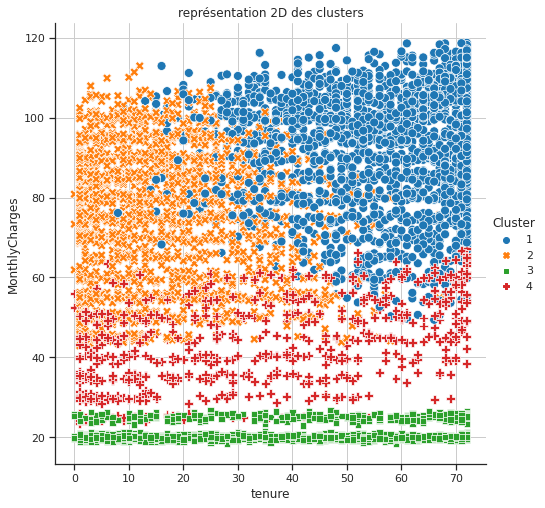

In [41]:
#Représentation des clusters selon les paiements mensuels et la durée de vie des clients qui les composent
sns.relplot(data = df, x = 'tenure', y = 'MonthlyCharges', hue = 'Cluster', style = 'Cluster', s=80,  height = 7)
plt.title('représentation 2D des clusters')

#Nombre de clients par cluster
print(df.Cluster.value_counts(sort = False))

#À première vue, les clusters 2 et 3 semblent dictés par les frais mensuels,
#on apperçoit une séparation principalement horizontale entre ces clusters.
#Au contraire, les clusters 1 et 4 sont relativement égaux quant à leurs charges mensuelles,
#mais semblent séparés verticalement, par la durée de vie. les clients du cluster 1
#semblent avoir une courte durée de vie, dû à la concentration du cluster vers la gauche du graphique

#n.b. l'algorithme est calculé sur plus de deux axes, le graphique ci-dessous n'est donc pas une représentation
#exacte de la distribution des observations parmi les clusters.

Cluster  Churn
1        No       0.855881
         Yes      0.144119
2        No       0.524590
         Yes      0.475410
3        No       0.925950
         Yes      0.074050
4        No       0.750733
         Yes      0.249267
Name: Churn, dtype: float64

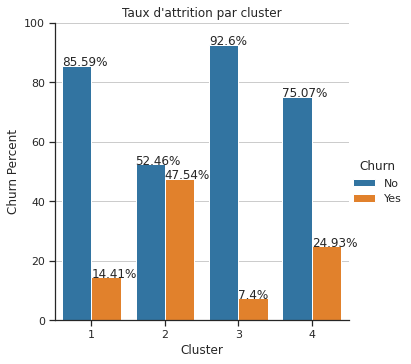

In [42]:
#histogramme de vérification des différences entre les clusters quant à leur attrition

df_percent = df.groupby(['Cluster'])['Churn'].value_counts(normalize=True) #décompte des valeurs
df_percent = df_percent.mul(100)                                           #transformation en pourcentage
df_percent = df_percent.rename('Churn Percent').reset_index()              #retour d'index afin de pouvoir les ajouter au graph

graph = sns.catplot(data=df_percent, x='Cluster',y='Churn Percent', hue='Churn', kind='bar')
graph.ax.set_ylim(0,100)
plt.title("Taux d'attrition par cluster")

#Fonction permettant d'ajouter les valeurs associées en colonnes sur le graphique directement
for p in graph.ax.patches:
    txt = str(p.get_height().round(2)) + '%' #Texte basé sur la hauteur (fonctionne car l'axe y est sur 100)
    txt_x = p.get_x()                        #Valeur en x de la barre associée
    txt_y = p.get_height()                   #Hauteur en y de la barre associée
    graph.ax.text(txt_x,txt_y,txt)           #Ajout du texte aux bonnes position

#Calcul du pourcentage d'attrition par Cluster
df.groupby(['Cluster'])['Churn'].value_counts(normalize = True)

#Le cluster 1 a un taux d'attrition extrêmement élevé comparés aux autres.
#Environ 48% des clients qui en font partie ont quittés.
#Le cluster 2 et 4 ont des taux d'attritions beaucoup plus bas que la moyenne globale

Cluster
1    92.225337
2    73.365757
3    21.078453
4    42.028592
Name: MonthlyCharges, dtype: float64


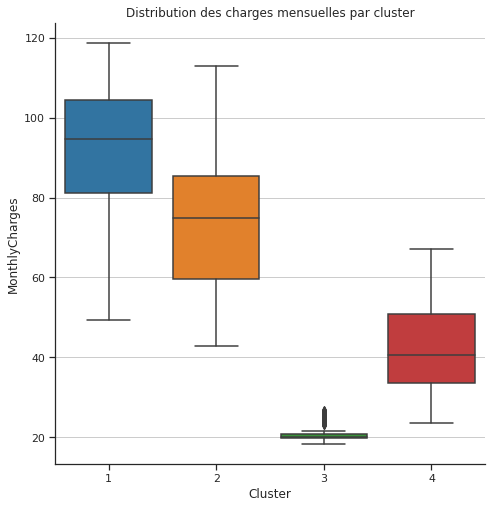

In [43]:
#Boîtes à moustache de la distribution des paiements mensuels par cluster
sns.catplot(data = df, y = "MonthlyCharges", x = "Cluster",kind='box', height = 7)
plt.title('Distribution des charges mensuelles par cluster')

print(df.groupby('Cluster')['MonthlyCharges'].mean())
#Le premier cluster a les paiements mensuels les plus élevés.
#Le cluster 2 est extrêmement homogène au niveau des paiements, environnant les 20$

Cluster
1    56.101813
2    14.551043
3    30.547182
4    31.737537
Name: tenure, dtype: float64


Durée de vie par cluster:


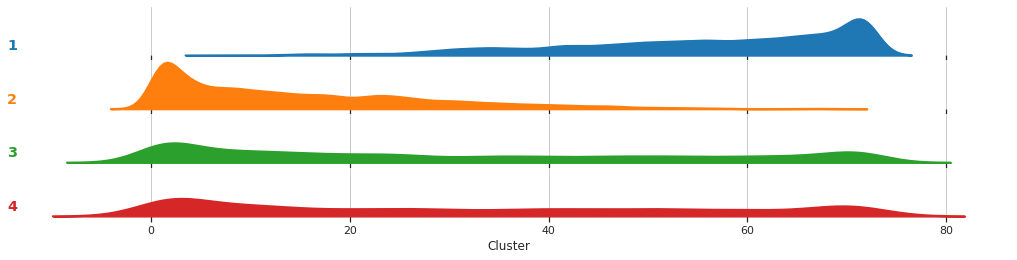

In [44]:
#Création d'un graphique démontrant la durée de vie par Cluster
g = sns.FacetGrid(df, row="Cluster", hue="Cluster", aspect=15, height=1)

# Création de la courbe et de l'aire
g.map(sns.kdeplot, "tenure",
      bw_adjust=0.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "tenure", clip_on=False, lw=2, bw_adjust=.5)

#Création d'une fonction qui met les labels de Cluster au début de chaque ligne
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, size = 'large',
            ha="left", va="center", transform=ax.transAxes)

#Application de la fonction
g.map(label, "Cluster")

#options retirant les titres et axes Y afin d'empêcher l'empiètement des graphiques l'un sur l'autre
g.figure.subplots_adjust(hspace=0.1)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

#Calcul de la durée de vie moyenne par cluster
print(df.groupby('Cluster')['tenure'].mean())

#Print pour un "titre" de graphique, pas possible de faire un titre régulier avec ce genre de visualisation
#étant donné que c'est essentiellement 4 graphiques empilés l'un sur l'autre.
print('\n\nDurée de vie par cluster:')

#On voit que la grande majorité des clients parmi le cluster 1 ont une durée de vie moyenne très courte,
#Le cluster 1 et 2 sont distribués assez égalitairement, avec une concentration au début et vers la fin des données
#Au contraire, le cluster 4 est presque exclusivement concentré dans les 60 mois et plus de relation.
#On pourrait supposer que les clients du cluster 1 et 4 sont similaires en caractéristiques, mais que
#les clients du segment 1 qui reste longtemps avec l'entreprise "migrent" vers le cluster 4.

Cluster
1    5179.632125
2    1074.273528
3     662.604784
4    1496.033651
Name: TotalCharges, dtype: float64


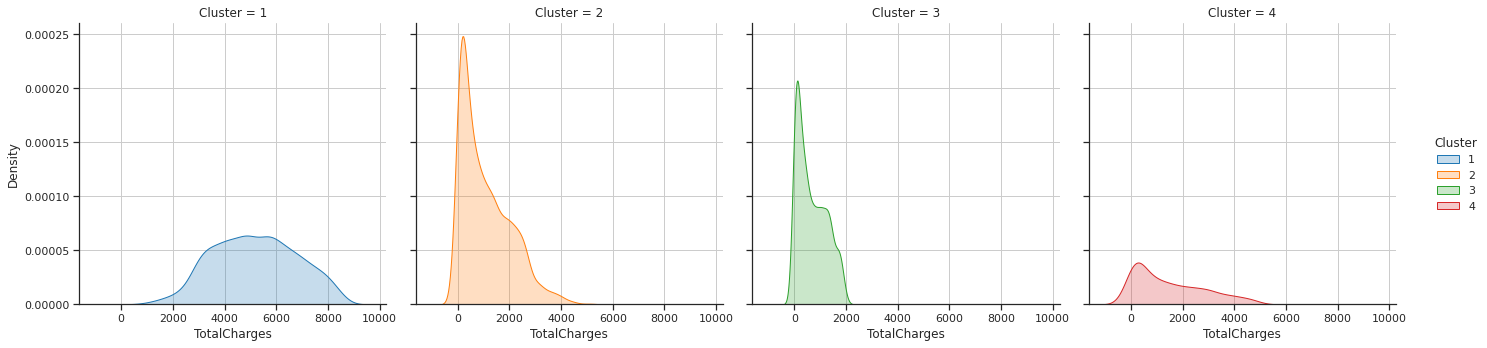

In [45]:
#Graphique de distribution des clients selon leur charges totales par Cluster
sns.displot(data = df, x = 'TotalCharges', fill = True, hue = 'Cluster',kind='kde',col = 'Cluster')
#Calcul de la moyenne de charges totales par Cluster
print(df.groupby('Cluster')['TotalCharges'].mean())
#Les trouvailles sont constantes avec les analyses précédentes, mais il est possible de bien voir que le cluster 2,
#malgré sa grande fidélité, fourni très peu de revenus en moyenne. Le segment 1 et 4 se ressemblent quant à leurs charges
#mensuelles, mais on voit que la distribution des charges totales du segment 4 est plus équilibrée et rentable.


 Cluster  PaymentMethod            
1        Bank transfer (automatic)    0.317062
         Credit card (automatic)      0.310088
         Electronic check             0.292887
         Mailed check                 0.079963
2        Electronic check             0.516766
         Mailed check                 0.201192
         Bank transfer (automatic)    0.144188
         Credit card (automatic)      0.137854
3        Mailed check                 0.485583
         Bank transfer (automatic)    0.217562
         Credit card (automatic)      0.216907
         Electronic check             0.079948
4        Electronic check             0.331378
         Mailed check                 0.233138
         Credit card (automatic)      0.225806
         Bank transfer (automatic)    0.209677
Name: PaymentMethod, dtype: float64

 Cluster  PaperlessBilling
1        Yes                 0.689447
         No                  0.310553
2        Yes                 0.691133
         No                  0.30

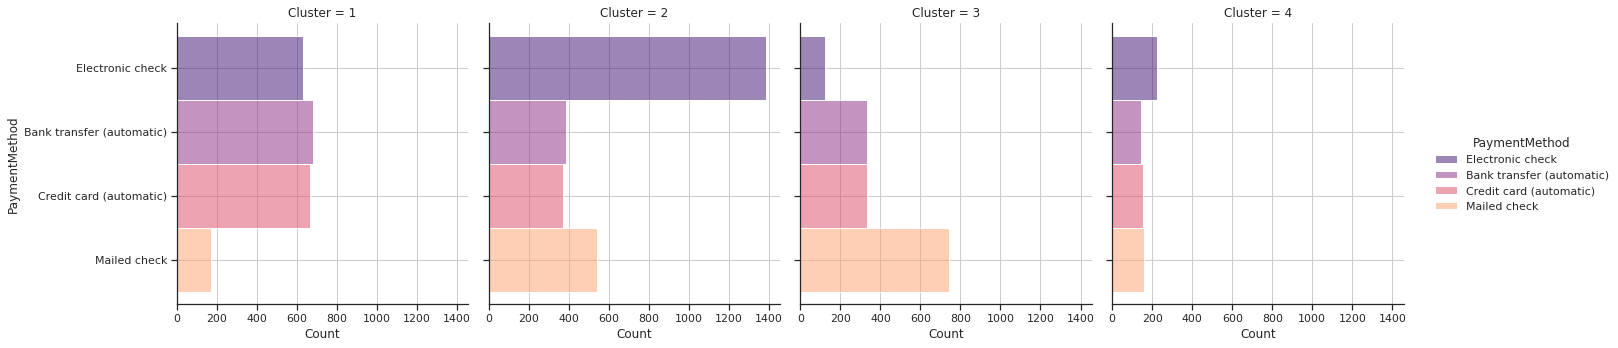

In [46]:
#Historamme horizontal de la méthode de paiement par cluster
sns.displot(data = df, y = 'PaymentMethod', hue='PaymentMethod', col = 'Cluster', palette = 'magma')

#Calcul de la distribution de la méthode de paiement par cluster
print("\n",df.groupby(['Cluster'])['PaymentMethod'].value_counts(normalize=True))
#Plus de la moitié des clients du cluster 1 payent par chèque électronique, le type de paiement le plus lié à l'attrition.
#Ceci contraste encore une fois avec le cluster 4, où la distribution des modes de paiements est beaucoup plus égalitaire.

#Distribution du type de facturation par cluster
print("\n",df.groupby(['Cluster'])['PaperlessBilling'].value_counts(normalize=True))
#3 des 4 clusters ont une plus grande proportion de client ayant la facture en ligne. 
#Le cluster 2 est une exception notable à la règle, avec près de 70% de ses clients qui préfèrent une facture papier


 Cluster  InternetService
1        Fiber optic        0.662947
         DSL                0.337053
2        Fiber optic        0.622206
         DSL                0.377794
3        No                 1.000000
4        DSL                1.000000
Name: InternetService, dtype: float64


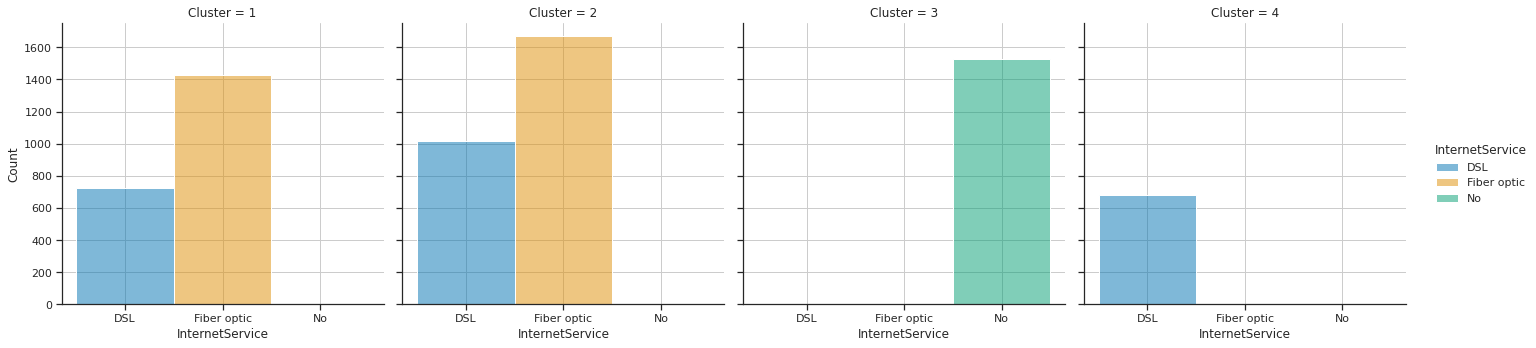

In [47]:
#histogramme de distribution du type d'Internet par Cluster
sns.displot(data = df, x = 'InternetService', hue='InternetService', col = 'Cluster', palette = 'colorblind')

#Calcul de la distribution du type d'Internet par Cluster
print("\n",df.groupby(['Cluster'])['InternetService'].value_counts(normalize=True))
#La distribution de cette variable est très intéressante. Les clusters 1 et 4 sont relativement similaire ayant 1/3 des clients
#avec un Internet DSL et le 2/3 avec la fibre optique. aucun client du cluster 2 n'a l'Internet et le cluster 3 est composé
#uniquement de clients ayant un Internet DSL. Il semblerait que cette variable aille une importance élevée quand à la
#segmentation des clients.


 Cluster  Contract      
1        Two year          0.401209
         One year          0.340772
         Month-to-month    0.258020
2        Month-to-month    0.902385
         One year          0.085693
         Two year          0.011923
3        Two year          0.418087
         Month-to-month    0.343381
         One year          0.238532
4        Month-to-month    0.551320
         Two year          0.236070
         One year          0.212610
Name: Contract, dtype: float64


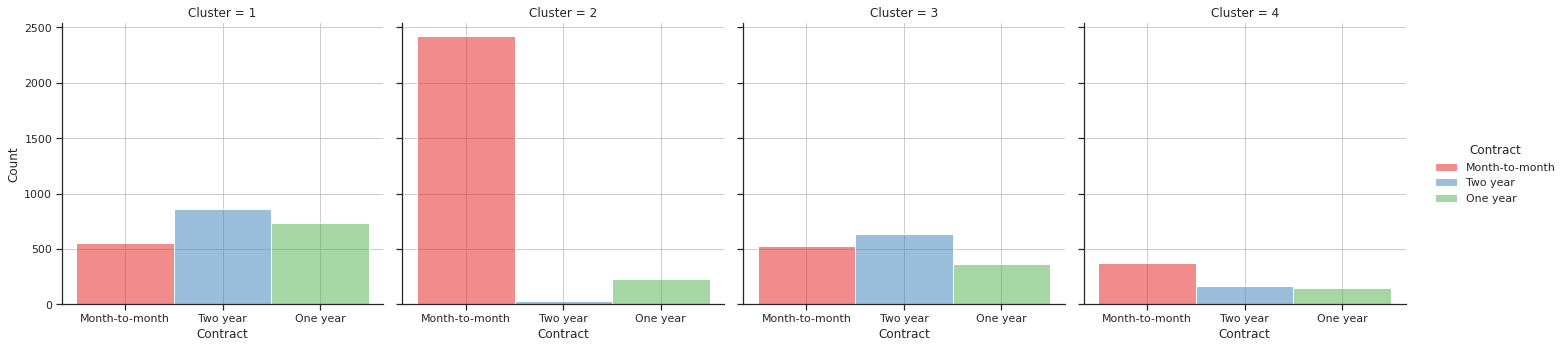

In [48]:
#Histogramme du type de contrat par Cluster
sns.displot(data = df, x = 'Contract', hue='Contract', col = 'Cluster', palette = 'Set1')

#Calcul de la distribution du type de contrat par Cluster
print("\n",df.groupby(['Cluster'])['Contract'].value_counts(normalize=True))
#90% des clients du cluster 1 ont des contrats mensuels! Ce type de contrat a le plus haut taux d'attrition, expliquant encore
#une des raisons derrière l'attrition élevée de ce cluster. Seulement 1% du cluster 1 a un contrat de 2 ans. Au contraire,
#Le cluster 2 et 4 ont une grande proportion de leur client avec des contrats de 2 ans, expliquant potentiellement pourquoi
#leurs taux d'attrition sont aussi faibles.

Cluster  PhoneService
1        Yes             1.0
2        Yes             1.0
3        Yes             1.0
4        No              1.0
Name: PhoneService, dtype: float64 

Cluster  MultipleLines   
1        Yes                 0.737796
         No                  0.262204
2        No                  0.611773
         Yes                 0.388227
3        No                  0.775885
         Yes                 0.224115
4        No phone service    1.000000
Name: MultipleLines, dtype: float64


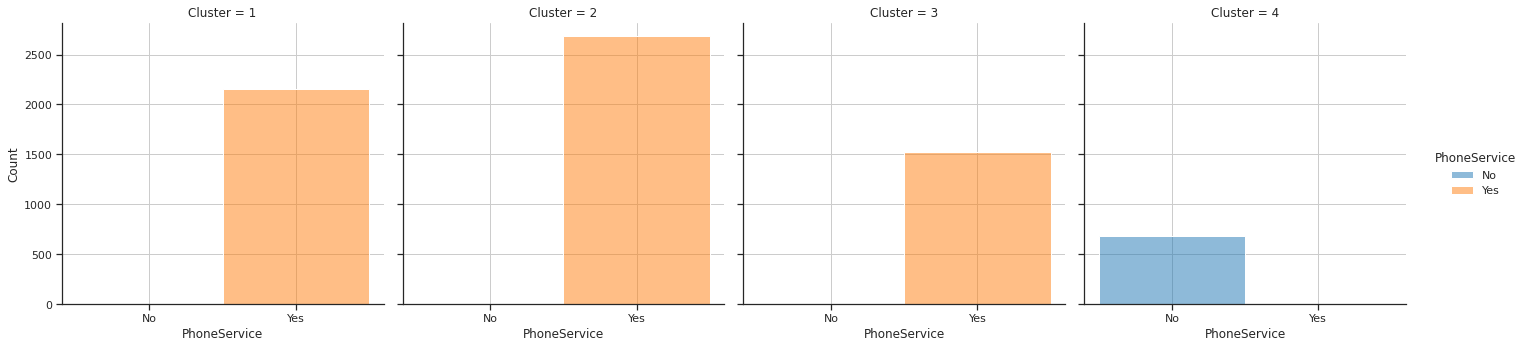

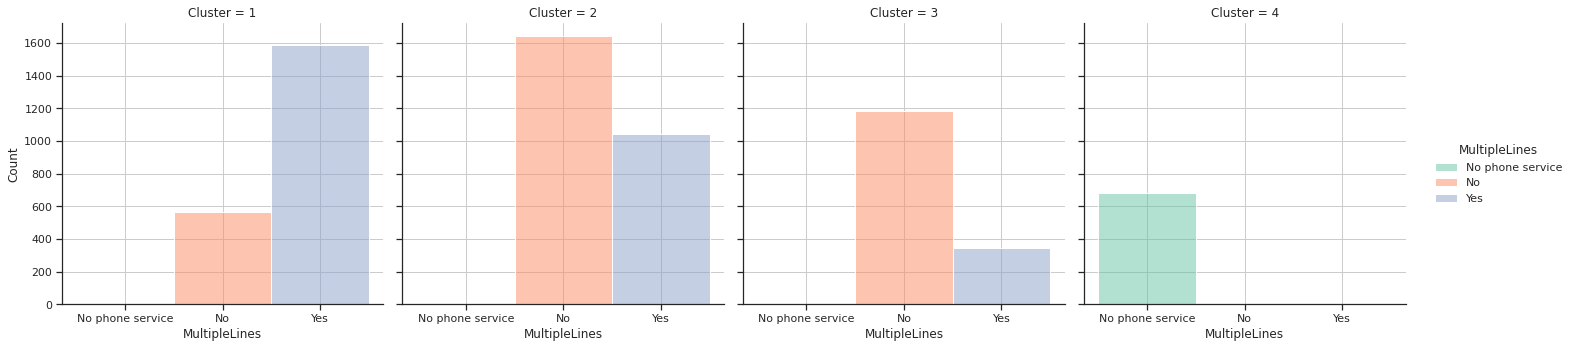

In [49]:
#Observations sur le status de service téléphonique par cluster
sns.displot(data = df, x = 'PhoneService', hue='PhoneService', col = 'Cluster')

print(df.groupby(['Cluster'])['PhoneService'].value_counts(normalize=True),'\n')
#Surprennament, TOUS les clients des clusters 1,2 et 4 ont ce service 
#tandis qu'AUCUN clients du cluster 3 a une ligne téléphonique

#Pourcentage de clients ayant plus d'une ligne téléphonique par cluster
sns.displot(data = df, x = 'MultipleLines', hue='MultipleLines', col = 'Cluster',  palette = 'Set2')
print(df.groupby(['Cluster'])['MultipleLines'].value_counts(normalize=True))

#Le cluster 1, où l'attrition est élevée, a une proportion plus élevée de clients ayant plusieurs lignes que le cluster 2.
#Aussi, 73% des clients du cluster 4 ont plus d'une ligne téléphonique, une proportion très élevée en comparaison à la moyenne

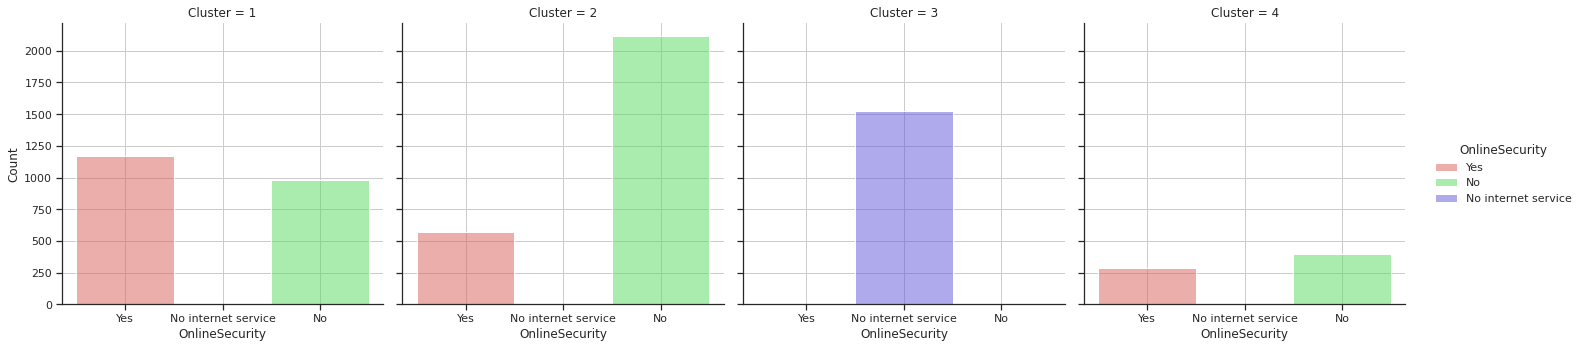

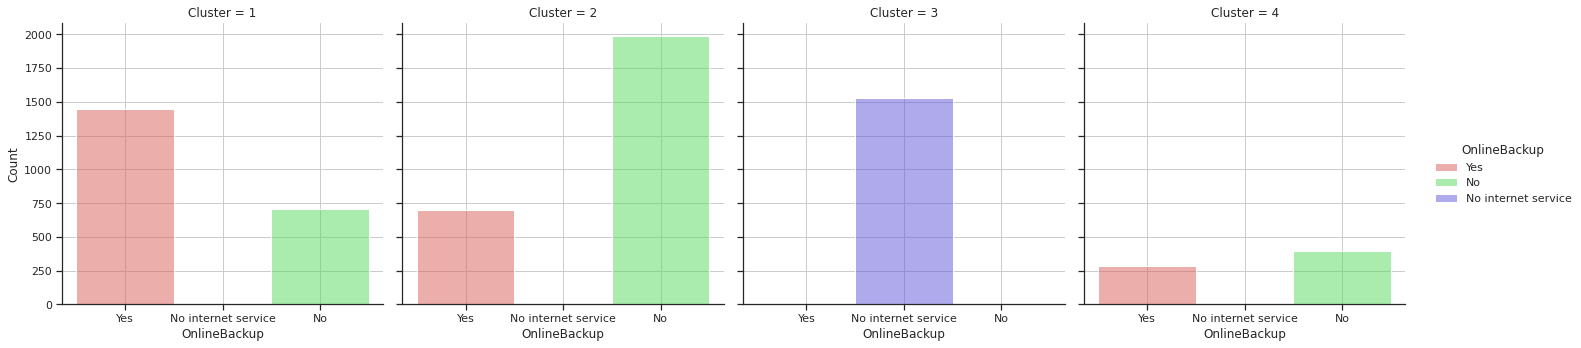

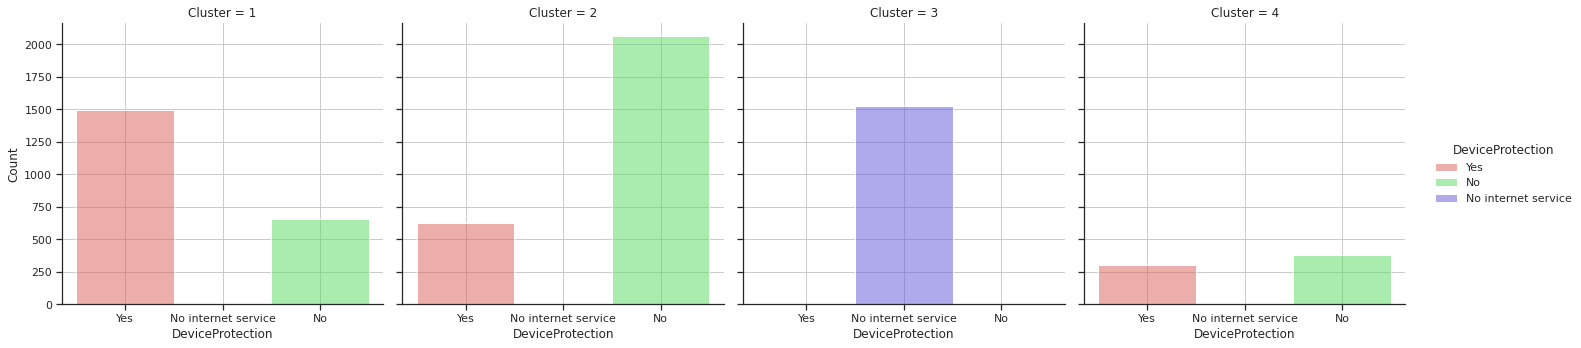

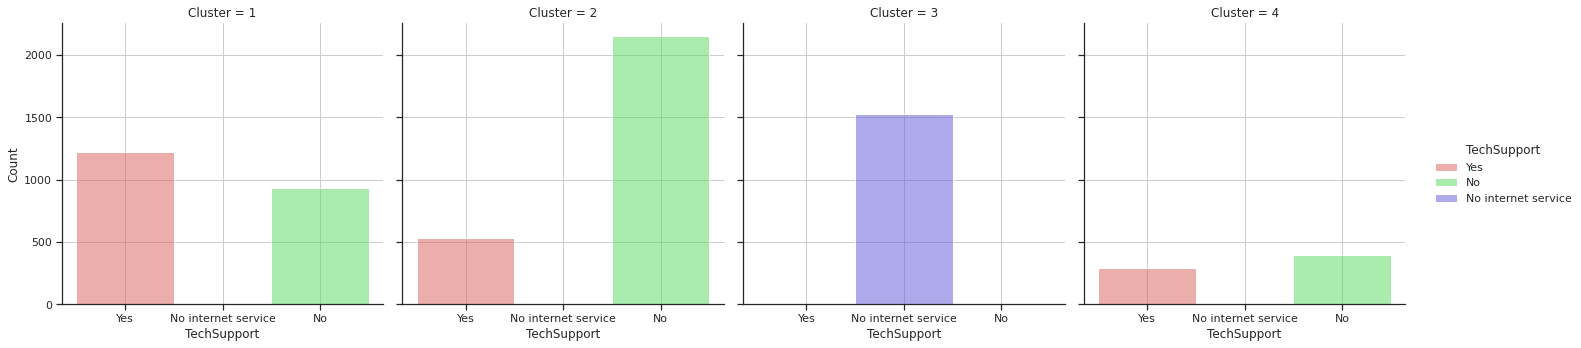

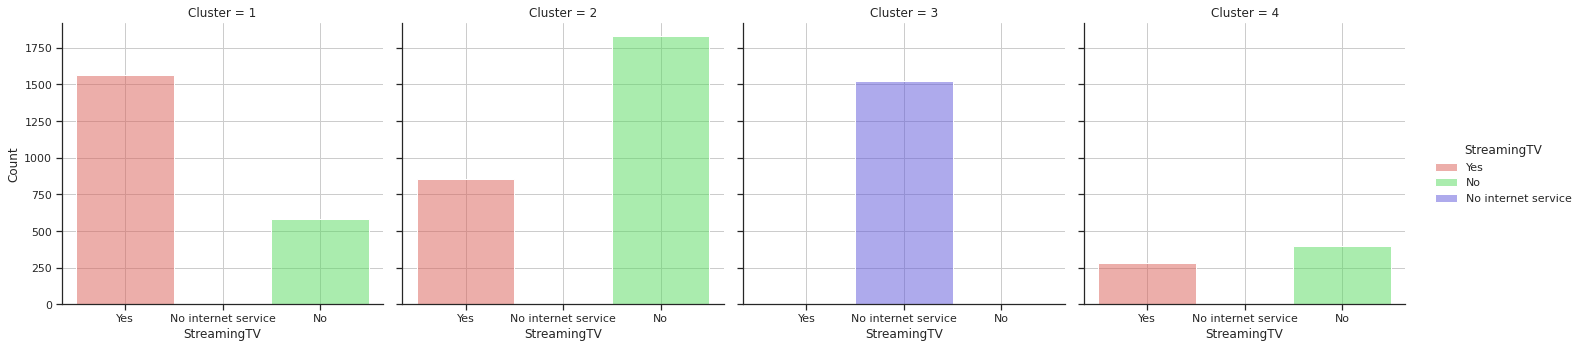

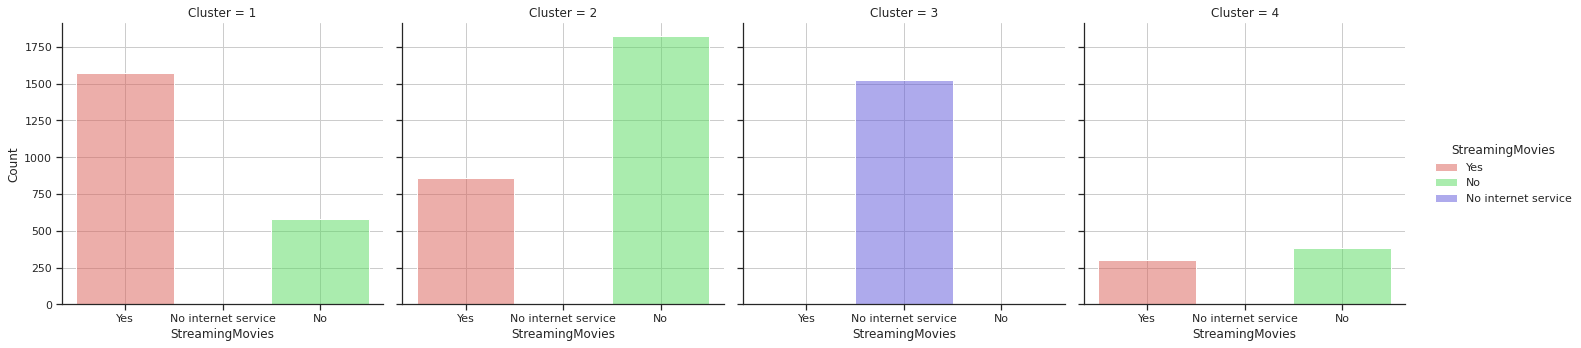

In [50]:
#Vérification rapide des différences d'options par clusters
Options_cols = df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]

#Boucle itérative de décompte de modalité par cluster pour chaque option
for col in Options_cols:
    df = df.sort_values(col, ascending = False) #tri afin de toujours avoir le même ordre de colonnes et couleurs 
    sns.displot(data = df,  x = col, hue = col, col = 'Cluster', hue_order = ['Yes','No','No internet service'], palette = 'hls')
    #print(df.groupby(['Cluster'])[col].value_counts(normalize=True)) #distribution des valeurs par cluster, retiré pour breveté

#Il n'y a que des différences très minimes quant aux options selon les clusters (sauf le cluster 2 qui n'a pas d'Internet)
#Même avec un value_counts() par cluster, les différences sont minimes. Il a été retiré ici pour réduire la taille du print.
#Les options semblent réparties relativement également dans les clusters.

#### Statistiques démographiques sur les clusters


 Cluster  gender
1        Male      0.505811
         Female    0.494189
2        Female    0.501863
         Male      0.498137
3        Male      0.510485
         Female    0.489515
4        Male      0.514663
         Female    0.485337
Name: gender, dtype: float64


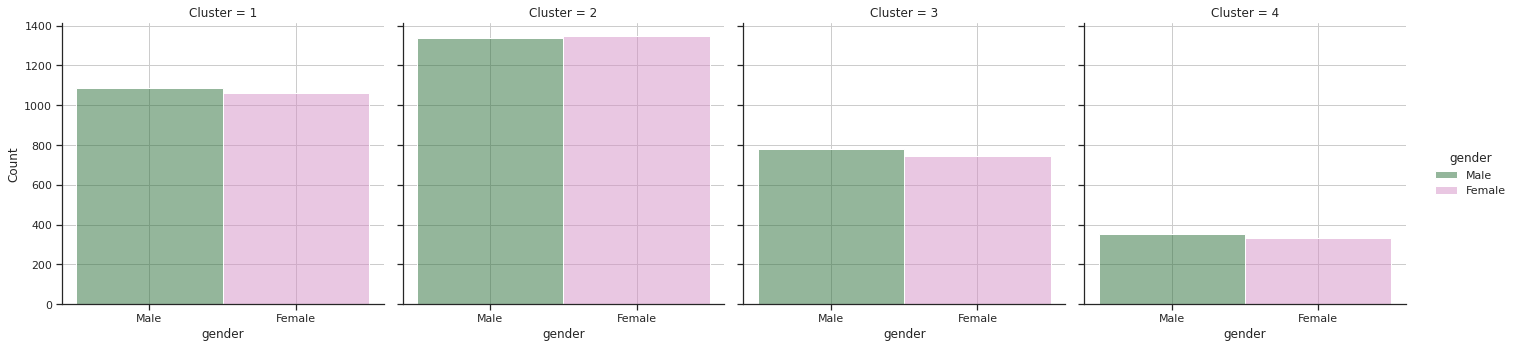

In [51]:
#Distribution des genres dans les clusters
sns.displot(data = df,  x = 'gender', hue = 'gender', col = 'Cluster', palette = 'cubehelix')

print(df.groupby(['Cluster'])['gender'].value_counts(normalize=True))
#La distribution des genres et très égales peu importe les clusters. 
#On peut potentiellement conclure que cette variable n'a peu d'importance dans cette segmentation.


 Cluster  Partner
1        Yes        0.701534
         No         0.298466
2        No         0.685544
         Yes        0.314456
3        No         0.516383
         Yes        0.483617
4        No         0.543988
         Yes        0.456012
Name: Partner, dtype: float64


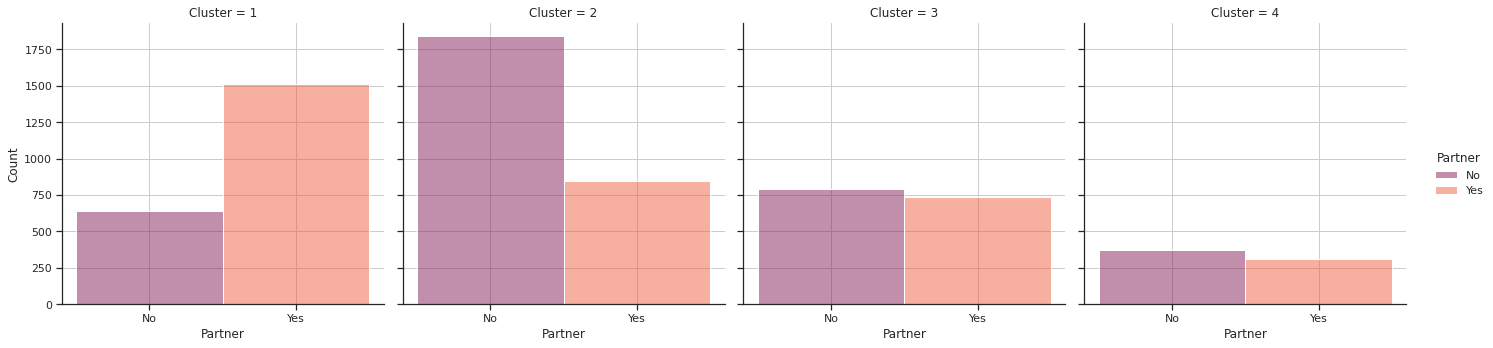

In [52]:
#Pourcentage des clients en couple par cluster
sns.displot(data = df,  x = 'Partner', hue = 'Partner', col = 'Cluster', palette = 'rocket')

print(df.groupby(['Cluster'])['Partner'].value_counts(normalize=True))
#Les clusters 2 et 3 semblent assez égaux quant au ratio de client célibataire ou en couple. Le cluster 1 contient
#beaucoup plus de célibataires(68%) que le cluster 4(30%).

Cluster  Kids
1        No      0.642492
         Yes     0.357508
2        No      0.816692
         Yes     0.183308
3        No      0.579292
         Yes     0.420708
4        No      0.697947
         Yes     0.302053
Name: Kids, dtype: float64


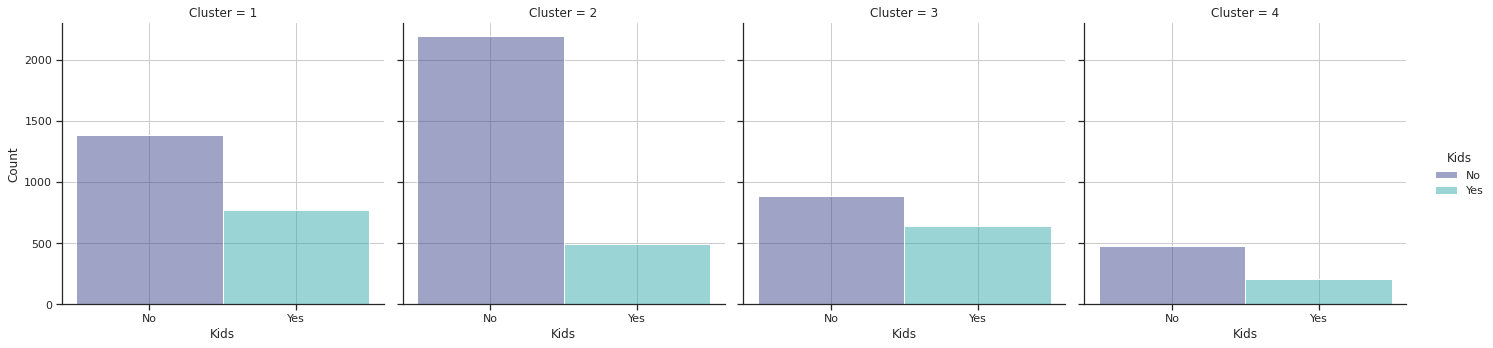

In [53]:
#Pourcentage des clients ayant des enfants par cluster
sns.displot(data = df,  x = 'Kids', hue = 'Kids', col = 'Cluster', palette = 'mako')

print(df.groupby(['Cluster'])['Kids'].value_counts(normalize=True))
#Les clients du cluster 1 sont les moins portés à avoir des enfants, le cluster 4 a environ 2x plus de chance d'en avoir.
#Suprenamment, le cluster 2 a le plus haut pourcentage relatif de clients ayant des enfants à leur charge


 Cluster   
1        0    0.797768
         1    0.202232
2        0    0.794709
         1    0.205291
3        0    0.965924
         1    0.034076
4        0    0.847507
         1    0.152493
Name: SeniorCitizen, dtype: float64


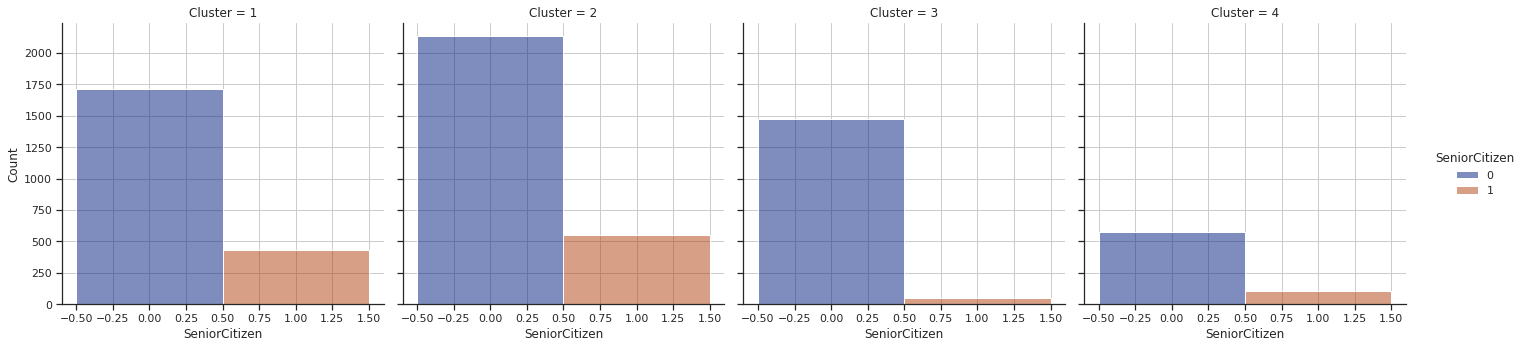

In [54]:
#Catégorisation de SeniorCitizen afin de représenter la variable adéquatement dans les graphiques
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')

#Pourcentage des clients ayant 65 ans ou plus par cluster
sns.displot(data = df,  x = 'SeniorCitizen', hue = 'SeniorCitizen', col = 'Cluster', palette = 'dark')

print(df.groupby(['Cluster'])['SeniorCitizen'].value_counts(normalize=True))
#Surprenament, les clusters 1 et 4 ont les plus hauts pourcentages de clients plus âgés.
#Le cluster 2 a une très faible concentration de clients âgés. Pourtant, aucun de ces clients ont un service Internet.